# Overview

This is a write-up of a project that uses planet labs imagery to find the coastline in provided imagery.

The examples will only use two different images to show the results.

A coastline only image
![](images/converted_to_RGB/coastline_im.jpg)

and an image with islands
![](images/converted_to_RGB/islnad_im.jpg)

#Project Start

The imagery is in the tiff file format with a total of 5 image layers. These layers are red, blue, green, near-infrared, and infrared image layers. The pixel values of these images are in the unsigned int16 format.

Since the edge detection techniques that will be used in this project require images in RGB with unsigned int8 pixels one of the first tasks is converting the tiff images into RGB images.

This is done using a combination of Gdal and scikit-image.

Since the original images contain 5 layers of information it is not possible to just pull out the RGB layers and not have information loss. Doing so would result in the image below.

![](images/unaltered_converted_to_RBG/coastline_im.png)

Instead, a Gdal the conversion function translate is used to select the desired image bands for conversion, RGB in this case, the pixel range for those bands is rescaled. Which leads to a much better image conversion as shown below.

![](images/converted_to_RGB/coastline_im.jpg)

Sckit-image is used to rescale the unsigned int16 pixel values into unsigned int8.

In [1]:
# command to install opencv using Anaconda
# conda install -c conda-forge opencv
# if after installing and opencv will not import try conda update ffmpeg

from skimage import exposure, img_as_ubyte, io
# io to read the image, img_as_ubyte to convert to int8, img_as_uint to convert to int16
import numpy as np
# numpy is needed stack the 2D matrix's in the correct order
#gdal to convert the image into a useable contrast level
from osgeo import gdal
import time

def convert_tiff_to_rgb_int8(path_to_image, tiff_scaled_placeholder="output_temp.tiff", exponents=None):
    """
    :param exponents: The conversion algorithm requires an exponent that controls the rescaled pixel std, a single list value provides and exponent that will be used on all the layers. You can also use an exponent for each layer being rescaled
    :param path_to_image:
    :param tiff_scaled_placeholder: Gdal translate outputs a file by default. This just provides a default name for that file
    :return: 3D numpy array
    """
    if exponents is None:
        exponents = [0.5]
    ds = gdal.Open(path_to_image)
    stats = [ds.GetRasterBand(i+1).GetStatistics(True, True) for i in range(ds.RasterCount)]
    pixel_min = 70000  # set to above the range of pixel values 65535
    pixel_max = -1  # set below the range of the pixel values 0
    for index in range(0, 3):
        band = stats[index]
        if band[0] < pixel_min:
            pixel_min = band[0]
        if band[1] > pixel_max:
            pixel_max = band[1]

    gdal.Translate(tiff_scaled_placeholder, ds, bandList = [3,2,1], creationOptions = ['COMPRESS=DEFLATE', 'PHOTOMETRIC=RGB'], exponents= exponents, scaleParams=[[pixel_min, pixel_max, 0, 65535]])
    time.sleep(1)  # give a few seconds for image i/o to occur
    tiff_image = io.imread(tiff_scaled_placeholder)
    uint8_by_ski = img_as_ubyte(exposure.rescale_intensity(tiff_image))
    # can also normalize to [0, 255] with opencv
    # uint8_by_cv2 = cv2.normalize(temp, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return uint8_by_ski

# convert both of the images
coastline_im = convert_tiff_to_rgb_int8("images/original/671610_2013-07-21_RE5_3A_Analytic_clip.tif")

island_im = convert_tiff_to_rgb_int8("images/original/671710_2013-07-21_RE5_3A_Analytic_clip.tif")



Warning 1: images/original/671610_2013-07-21_RE5_3A_Analytic_clip.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples do

Now that the images are in the correct format it is possible to use them to perform coastline edge detection.

# Canny Edge
The first edge detection method used is Canny edge detection, a commonly used edge detection algorithm.

In [2]:
import cv2

blur = (5, 5)  # set Gaussian blur convolution to 5x5 matrix
gray_coastline_im = cv2.cvtColor(coastline_im, cv2.COLOR_BGR2GRAY)
coastline_blur_im = cv2.GaussianBlur(gray_coastline_im, blur, 0)
coastline_canny_im = cv2.Canny(coastline_blur_im, 50, 150)

cv2.imwrite("images/canny results/canny_coastline_edge.jpg", coastline_canny_im)

True

Canny edge detection results entirely depend on the min and max thresholds used in the thresholding.

To get good results you need good threshold values.

One way to do this is to pick values based on the pixel distribution.


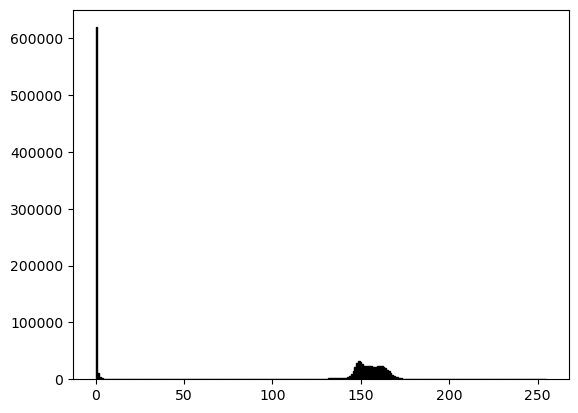

In [3]:
import matplotlib.pyplot as plt
rbg_coastline_im = cv2.imread("images/converted_to_RGB/coastline_im.jpeg")
rbg_island_im = cv2.imread("images/converted_to_RGB/island_im.jpeg")

gray_coastline_im = cv2.cvtColor(rbg_coastline_im, cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([gray_coastline_im], [0], None, [256], [0, 256])
plt.hist(gray_coastline_im.ravel(), bins=256, fc='k', ec='k')
plt.show()

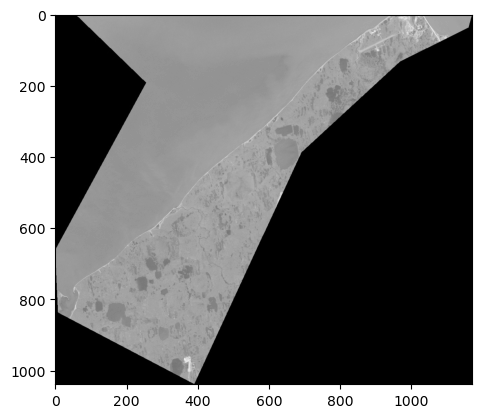

In [4]:
# gray scale view of the image
plt.imshow(gray_coastline_im, cmap='gray')
plt.show()

The pixels of the coastline image fall into a bimodal distribution.

These two separate pixel clusters likely indicate land or water.

This property enables auto-selection of the mean pixel for each separate cluster.

In [5]:
coastline_im_with_no_low_pixels = gray_coastline_im[gray_coastline_im > 50]
int(coastline_im_with_no_low_pixels.mean())

155

Now to apply Canny edge detection.

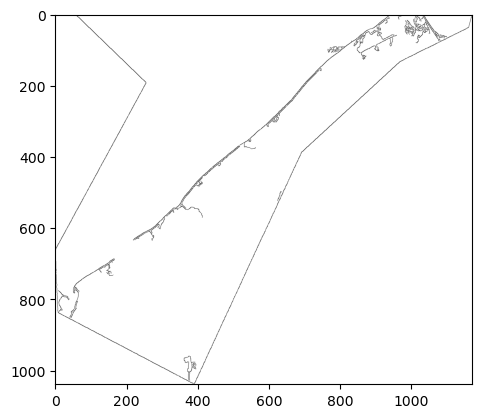

In [6]:
coastline_im_upper_dist_pixels = gray_coastline_im[gray_coastline_im > 50]
coastline_im_lower_dist_pixels = gray_coastline_im[gray_coastline_im < 50]

gray_coastline_im = cv2.cvtColor(coastline_im, cv2.COLOR_BGR2GRAY)
coastline_blur_im = cv2.GaussianBlur(gray_coastline_im, blur, 0)
coastline_canny_im = cv2.Canny(coastline_blur_im,
                               int(coastline_im_lower_dist_pixels.mean()), int(coastline_im_upper_dist_pixels.mean()))
plt.imshow(coastline_canny_im, cmap='binary')
plt.show()

The resulting edge map is still as accurate as it could be.

These results may be refined by using a threshold value one standard deviation either above or below the mean.

Greater or lesser values can be used but are avoided to keep the example simple.

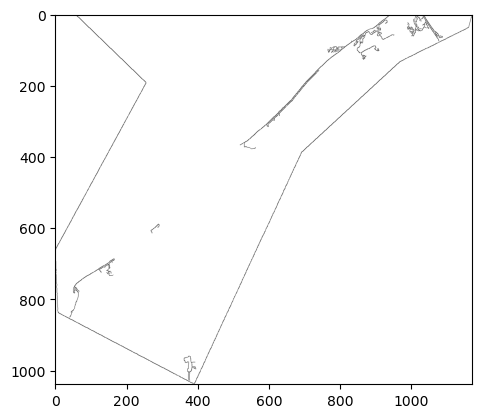

In [7]:
gray_coastline_im = cv2.cvtColor(coastline_im, cv2.COLOR_BGR2GRAY)
coastline_blur_im = cv2.GaussianBlur(gray_coastline_im, blur, 0)
sigma = 0.33
upper_one_sigma_dev = int(min(255, (1.0 + sigma) * int(coastline_im_upper_dist_pixels.mean())))

coastline_canny_im = cv2.Canny(coastline_blur_im, int(coastline_im_lower_dist_pixels.mean()), upper_one_sigma_dev)
plt.imshow(coastline_canny_im, cmap='binary')
plt.show()

No major improvement is shown, onto the next method.

# ISODATA

The second edge detection algorithm used is ISODATA thresholding.

A clustering algorithm that used the images infrared layer where the greatest difference between the pixels is noted to separate the pixels into two oceanic and landmass categories.

In [8]:
from skimage.filters import threshold_isodata
from skimage import img_as_uint

def isodata_thres_on_ir_layer(path_to_image, rebalance_pixels=True, name_placeholder="iso_tiff_placeholder.tiff", name_out="isodata.jpeg", save_im=False):
    """
    Does not work very well on low landmass images.

    :param rebalance_pixels:
    :param name_out:
    :param name_placeholder:
    :param path_to_image:
    :return:
    """
    if rebalance_pixels:
        ds = gdal.Open(path_to_image)
        stats = [ds.GetRasterBand(i+1).GetStatistics(True, True) for i in range(ds.RasterCount)]
        ir_layer_min = stats[3][0]
        ir_layer_max = stats[3][1]
        # only change here is that since the tiff output is no longer a three layer image we cannot use a RGB PHOTOMETRIC, Instead we use a gray scale setting MINISBLACK
        gdal.Translate(name_placeholder, ds, bandList = [4], creationOptions = ['COMPRESS=DEFLATE', 'PHOTOMETRIC=MINISBLACK'], exponents= [0.5], scaleParams=[[ir_layer_min, ir_layer_max, 0, 65535]])

    else:
        name_placeholder = path_to_image
    tif = io.imread(name_placeholder)
    thres = threshold_isodata(tif)
    result = tif > thres
    result = result.astype(int)
    result[result > 0] = 250  # convert all land pixels to 250 pixel value. Otherwise set to one
    result = result.astype(np.uint8)  # convert into the correct data type for opencv
    if save_im:
        io.imsave("images/isodata_results/" + name_out, img_as_uint(result))
    return result

![](images/isodata_results/isodata_non_edge_coastline.jpg)

Now apply canny edge detection to obtain the shoreline of the image.

Warning 1: images/original/671610_2013-07-21_RE5_3A_Analytic_clip.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples do

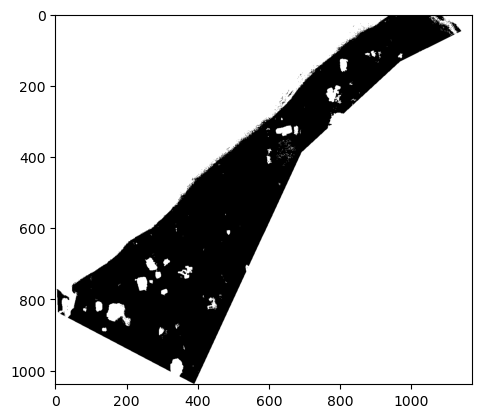

In [9]:
# demonstrating the ISODATA edge map

iso_im = isodata_thres_on_ir_layer("images/original/671610_2013-07-21_RE5_3A_Analytic_clip.tif")

plt.imshow(iso_im, cmap='binary')
plt.show()

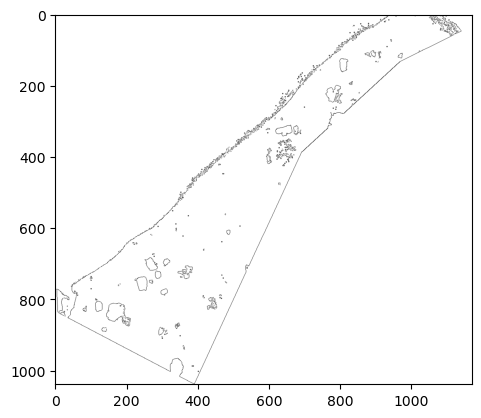

In [10]:

im_canny = cv2.Canny(iso_im, 50, 150)
plt.imshow(im_canny, cmap='binary')
plt.show()



ISODATA avoids using any threshold values but still does not result in an accurate edge map.

This problem grows if the image does not have a significant enough difference between the two-pixel groups.

Warning 1: images/original/671710_2013-07-21_RE5_3A_Analytic_clip.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples do

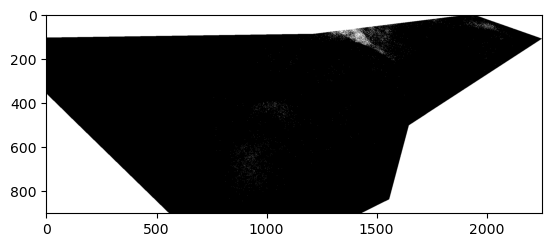

In [11]:
iso_im = isodata_thres_on_ir_layer("images/original/671710_2013-07-21_RE5_3A_Analytic_clip.tif")

plt.imshow(iso_im, cmap='binary')
plt.show()

# Holistically Nested Edge Detection

It is possible to find a good edge map by grid searching canny edge detection hyper parameters yet it requires an increased level of computational power.

You are also still stuck with having some method of determining which of the resulting canny images is a good enough fit.

A solution can be achieved using a combination of holistically nested edge detection and an image matching algorithm.

Holistically nested edge detection is one of the most accurate edge map methods but has edge maps that are  wider than a single pixel.

Not normally a good solution where single pixel accuracy is needed.

This difficultly can be overcome for this problem though.

The first step will be to create a class that will re-crop the image size to the correct size for the Holistic Neural Network.

In [12]:
# This code is taken from the wonderful blogpost from pyimagesearch blog by Adrian Rosenbrock
# https://pyimagesearch.com/2019/03/04/holistically-nested-edge-detection-with-opencv-and-deep-learning/
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H
        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]

Next is to load in the Neural Network model and attach the cropping class.

The to view the results of the holistic edge map


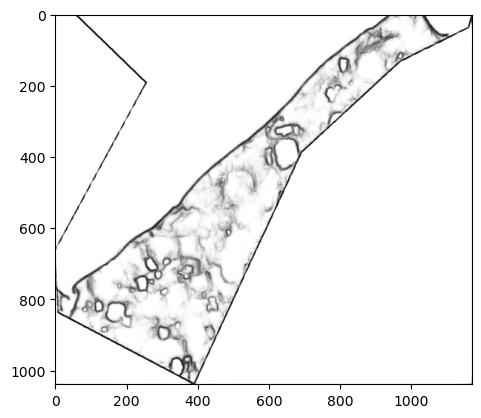

In [13]:
protoPath = "hed_model/deploy.prototxt"
modelPath = "hed_model/hed_pretrained_bsds.caffemodel"
net_demo = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
cv2.dnn_registerLayer("Crop", CropLayer)



# Now to get the image ready to be feed into the Neural network.
(H, W) = coastline_im.shape[:2]
blob_demo = cv2.dnn.blobFromImage(coastline_im, scalefactor=1.0, size=(W, H),
mean=(104.00698793, 116.66876762, 122.67891434),  # RBG mean of pixel values for each layer
swapRB=False, crop=False)

# Now to feed the image through the network.
net_demo.setInput(blob_demo)
hed_demo = net_demo.forward()
hed_demo = cv2.resize(hed_demo[0, 0], (W, H))
hed_demo = (255 * hed_demo).astype("uint8")

# Finally, to view the results of the holistic edge map
plt.imshow(hed_demo, cmap='binary')
plt.show()



The result is more than accurate enough to be used as intended.

The next step is to determine the method of image comparison.

In this project, two methods of image comparison are used.

The first is using a simple bitwise AND combined with a percentage of pixel drop-off.

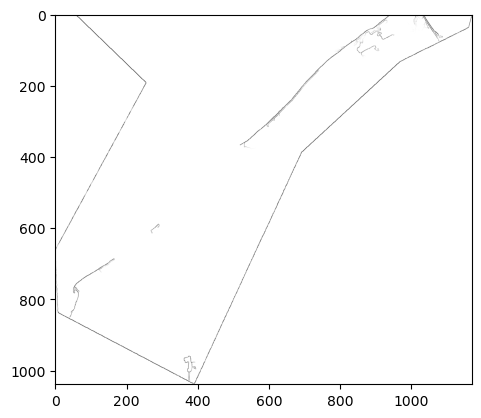

In [14]:
# coastline_canny_im, hed

temp_base = coastline_canny_im > 0
temp_base = temp_base + 0
np.sum(temp_base)  # 6981

bitwiseAnd = cv2.bitwise_and(hed_demo, coastline_canny_im)
plt.imshow(bitwiseAnd, cmap='binary')
plt.show()


In [15]:
temp_and = bitwiseAnd > 0
temp_and = temp_and + 0
np.sum(temp_and)  # 6613
difference = np.sum(temp_and) / np.sum(temp_base)
print(f"{difference:.2%}")

97.14%


Depending on imagery bitwise AND can perform well.

When it is not a good choice use the Structural Similarity Index (SSIM).

In [16]:
from skimage.metrics import structural_similarity as ssim

ssim_percentage_diff = ssim(hed_demo, coastline_canny_im)
print(f"{ssim_percentage_diff:.2%}")

79.19%


# Final Functionality

From here all that is needed is a function that combines all this.

In [17]:


def compare_edge_maps(im_1, im_2, fit_threshold=0.80, fit_type="ssim"):
    """
    comparison function for the two edge maps
    :param im_1:
    :param im_2:
    :param fit_threshold: percentage of pixel matching
    :param fit_type: what type of fit method
    :return: boolean
    """
    if fit_type == "ssim":
        if ssim(im_1, im_2) >= fit_threshold:
            return True
        else:
            return False

    elif fit_type == "bitwiseAnd":
        temp_base = im_2 > 0
        temp_base = temp_base + 0
        original_sum = np.sum(temp_base)  # 6981

        bitwiseAnd = cv2.bitwise_and(im_1, im_2)

        temp_and = bitwiseAnd > 0
        temp_and = temp_and + 0
        and_sum = np.sum(temp_and)  # 6613

        if (and_sum / original_sum ) >= fit_threshold:
            return True
        else:
            return False
    else:
        raise ValueError("You have failed to select a valid edge map comparison method")

def find_a_edge_map_fit(holestic_net_nn, image, canny_grid_step=50, fit_threshold=0.70, fit_type="ssim",
                        data_color_mean=(104.00698793, 116.66876762, 122.67891434), blur=(5,5),
                        canny_start_point=0, canny_end_point=255):
    """
    Grid search canny edge detection to fit a edge map percentage fit with Holistically Nested Edge Detection result

    :param holestic_net_nn:
    :param image:
    :param canny_grid_step:
    :param fit_threshold: percentage of pixel matching
    :param fit_type: what type of fit method
    :param data_color_mean: pixel mean of the image layers
    :param blur: blur convolution size
    :return:
    """
    (H, W) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(W, H),
    mean=data_color_mean,
    swapRB=False, crop=False)
    holestic_net_nn.setInput(blob)
    hed = holestic_net_nn.forward()
    hed = cv2.resize(hed[0, 0], (W, H))
    hed = (255 * hed).astype("uint8")

    gray_im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur_im = cv2.GaussianBlur(gray_im, blur, 0)

    canny_im = None

    stop_grid_search = False
    for canny_min in range(canny_start_point, canny_end_point, canny_grid_step):
        for canny_max in range(canny_start_point, canny_end_point, canny_grid_step):
            canny_im = cv2.Canny(blur_im, canny_min, canny_max)
            if compare_edge_maps(hed, canny_im, fit_threshold=fit_threshold, fit_type=fit_type):
                stop_grid_search =  True
                break

        if stop_grid_search:
            break

    if stop_grid_search:
        return canny_im
    else:
        return None

Now to apply.


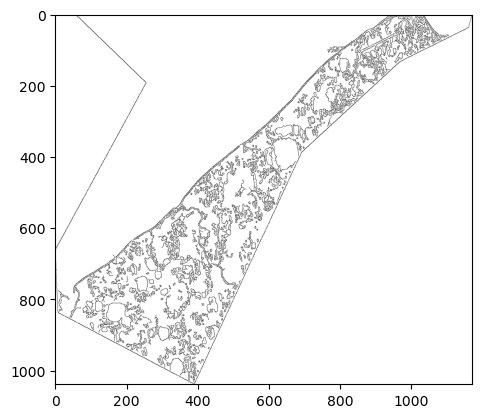

In [20]:

# image search time lowered
final_temp = find_a_edge_map_fit(net_demo, coastline_im)

plt.imshow(final_temp, cmap='binary')
plt.show()